# Model and configuration selection

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [16]:
from networks.cnn_v1 import CNNv1
from networks.cnn_v2 import CNNv2
from networks.cnn_v3 import CNNv3

sampling_rate = 100
dataset_path = "ecg_dataset/"
number_of_classes = 5

model = CNNv2(num_classes=number_of_classes, sampling_rate=sampling_rate)

# Getting data ready for training

In [17]:
from scripts.data_preparation import get_data_ready_for_training

(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    multi_label_binarizer,
) = get_data_ready_for_training(
    dataset_path=dataset_path,
    sampling_rate=model.sampling_rate(),
    scale_features=True,
    input_3D=model.need_3D_input(),
)

Loaded labels
Loaded ECG signals
Encoded labels
Scaled ECG signals
Split training data into training|validation


# Callbacks

In [3]:
from tensorflow._api.v2.v2.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    EarlyStopping(monitor="val_auc", verbose=1, patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_auc", patience=5, verbose=1, min_lr=0.0001),
]

# Model compilation

In [4]:
from tensorflow._api.v2.v2.keras.losses import BinaryCrossentropy
from tensorflow._api.v2.v2.keras.optimizers import Adam
from tensorflow._api.v2.v2.keras.metrics import BinaryAccuracy, Recall, Precision, AUC

model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(),
    metrics=[
        BinaryAccuracy(),
        Recall(),
        Precision(),
        AUC(multi_label=True),
    ],
)

# Model architecture

In [5]:
try:
    model.summary()
except ValueError:
    model.model_architecture().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000, 12, 1)]     0         
                                                                 
 cnn_block (CNNBlock)        (None, 5000, 12, 32)      448       
                                                                 
 cnn_block_1 (CNNBlock)      (None, 5000, 12, 64)      18752     
                                                                 
 cnn_block_2 (CNNBlock)      (None, 5000, 12, 128)     74368     
                                                                 
 cnn_block_3 (CNNBlock)      (None, 5000, 12, 256)     296192    
                                                                 
 cnn_block_4 (CNNBlock)      (None, 5000, 12, 512)     1182208   
                                                                 
 global_average_pooling2d (G  (None, 512)              0     

# Model training

In [6]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
)

Epoch 1/100
7214/7214 [==============================] - 836s 112ms/step - loss: 0.4667 - binary_accuracy: 0.7859 - recall: 0.3493 - precision: 0.6673 - auc: 0.7461 - val_loss: 0.4694 - val_binary_accuracy: 0.8014 - val_recall: 0.4280 - val_precision: 0.6912 - val_auc: 0.8127 - lr: 0.0010
Epoch 2/100
7214/7214 [==============================] - 786s 109ms/step - loss: 0.4055 - binary_accuracy: 0.8208 - recall: 0.5034 - precision: 0.7219 - auc: 0.8209 - val_loss: 0.4551 - val_binary_accuracy: 0.8062 - val_recall: 0.5758 - val_precision: 0.6424 - val_auc: 0.8451 - lr: 0.0010
Epoch 3/100
7214/7214 [==============================] - 793s 110ms/step - loss: 0.3825 - binary_accuracy: 0.8337 - recall: 0.5555 - precision: 0.7391 - auc: 0.8428 - val_loss: 0.4646 - val_binary_accuracy: 0.8266 - val_recall: 0.6506 - val_precision: 0.6725 - val_auc: 0.8592 - lr: 0.0010
Epoch 4/100
7214/7214 [==============================] - 800s 111ms/step - loss: 0.3674 - binary_accuracy: 0.8433 - recall: 0.5885

# Saving model

In [7]:
model.save(filepath=f"saved_models/{model.model_name()}", save_format="tf")

INFO:tensorflow:Assets written to: saved_models/cnn_v2_500\assets


INFO:tensorflow:Assets written to: saved_models/cnn_v2_500\assets


# Model loading

In [18]:
from tensorflow import keras

#model = keras.models.load_model(f"saved_models/cnn_v2")

# Model evaluation

In [19]:
y_pred_proba = model.predict(X_test)

68/68 [==============================] - 13s 69ms/step


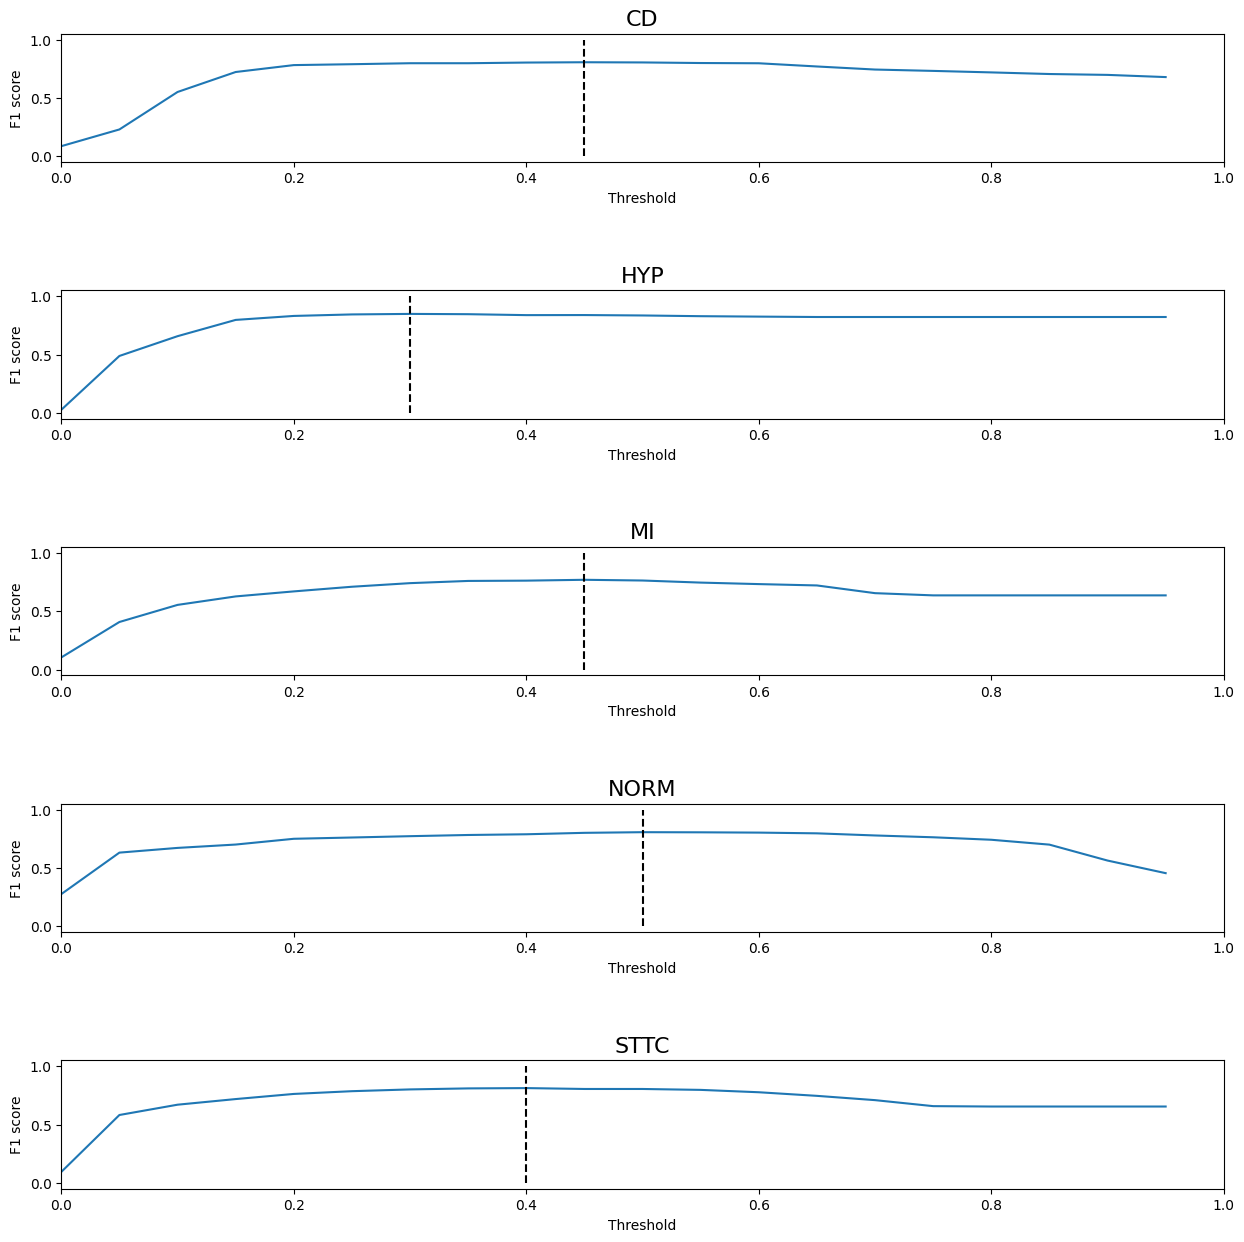

In [20]:
from scripts.data_evaluation import plot_optimal_thresholds
import os

file_name = "optimal_thresholds.png"
output_directory = f"optimal_thresholds_visualizations/{model.model_name()}/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

optimal_thresholds = plot_optimal_thresholds(
    y_test, y_pred_proba, file_path=os.path.join(output_directory, file_name)
)

In [21]:
y_pred = (y_pred_proba > optimal_thresholds) * 1

In [10]:
# keras in-built way
import numpy as np
import pandas as pd
import os

file_name = "model_evaluation.csv"
output_directory = f"saved_data/{model.model_name()}/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

model_evaluation = np.array(model.evaluate(X_test, y_test))
model_evaluation = np.round(model_evaluation, 3)
model_evaluation_df = pd.DataFrame(
    data=model_evaluation, index=model.metrics_names
).transpose()
model_evaluation_df.to_csv(os.path.join(output_directory, file_name))

1080/1080 [==============================] - 34s 31ms/step - loss: 0.3531 - binary_accuracy: 0.8511 - recall: 0.6564 - precision: 0.7392 - auc: 0.8850


In [22]:
# custom way
import numpy as np
import pandas as pd
import os
import tensorflow as tf

file_name = "model_evaluation_optimized.csv"
output_directory = f"saved_data/{model.model_name()}/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

binary_crossentropy_loss = tf.keras.losses.BinaryCrossentropy()
loss = binary_crossentropy_loss(y_test, y_pred_proba)

binary_accuracy = tf.keras.metrics.BinaryAccuracy()
_ = binary_accuracy.update_state(y_test, y_pred)

recall = tf.keras.metrics.Recall()
_ = recall.update_state(y_test, y_pred)

precision = tf.keras.metrics.Precision()
_ = precision.update_state(y_test, y_pred)

auc = tf.keras.metrics.AUC(multi_label=True)
_ = auc.update_state(y_test, y_pred)

model_evaluation = np.array(
    [
        loss.numpy(),
        binary_accuracy.result().numpy(),
        recall.result().numpy(),
        precision.result().numpy(),
        auc.result().numpy(),
    ]
)
model_evaluation = np.round(model_evaluation, 3)
model_evaluation_df = pd.DataFrame(
    data=model_evaluation,
    index=["loss", "binary_accuracy", "recall", "precision", "auc"],
).transpose()
model_evaluation_df.to_csv(os.path.join(output_directory, file_name))

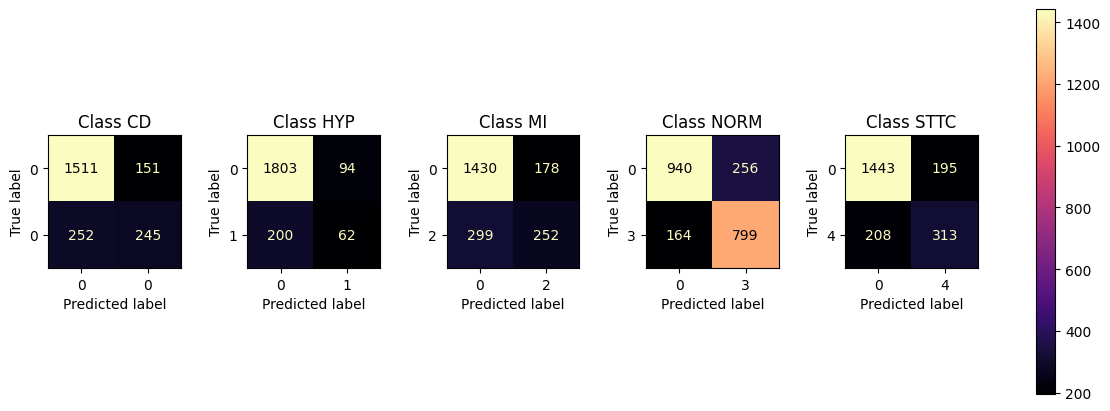

In [23]:
from scripts.data_evaluation import plot_confusion_matrix
import os

file_name = "confusion_matrix.png"
output_directory = f"saved_images/{model.model_name()}/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

plot_confusion_matrix(
    y_test,
    y_pred,
    multi_label_binarizer.classes_,
    file_path=os.path.join(output_directory, file_name),
)

In [24]:
from sklearn.metrics import classification_report
import pandas as pd

print(
    classification_report(
        y_test, y_pred, target_names=list(multi_label_binarizer.classes_)
    )
)

              precision    recall  f1-score   support

          CD       0.62      0.49      0.55       497
         HYP       0.40      0.24      0.30       262
          MI       0.59      0.46      0.51       551
        NORM       0.76      0.83      0.79       963
        STTC       0.62      0.60      0.61       521

   micro avg       0.66      0.60      0.63      2794
   macro avg       0.60      0.52      0.55      2794
weighted avg       0.64      0.60      0.61      2794
 samples avg       0.61      0.62      0.60      2794



In [25]:
report = classification_report(
    y_test, y_pred, target_names=list(multi_label_binarizer.classes_), output_dict=True
)
df = pd.DataFrame(report).transpose().round(decimals=3)
df.to_csv(f"saved_data/{model.model_name()}/classification_report.csv")

# Show predictions on sample patient

In [26]:
class_names = np.array(multi_label_binarizer.classes_)

patient_ecg = np.expand_dims(X_test[0], axis=0)
patient_ecg_prob = (model.predict(patient_ecg) > optimal_thresholds) * 1
sorted_categories = np.argsort(patient_ecg_prob[0])[:-6:-1]

for i in range(5):
    print(
        f"{class_names[sorted_categories[i]]}: {patient_ecg_prob[0][sorted_categories[i]]}"
    )

1/1 [==============================] - 0s 165ms/step
NORM: 1
STTC: 0
MI: 0
HYP: 0
CD: 0


In [27]:
sample_patients_predictions_df = pd.DataFrame()

for index in range(15):
    patient_ecg = np.expand_dims(X_test[index], axis=0)
    patient_ecg_prob = (model.predict(patient_ecg) > optimal_thresholds) * 1
    sample_patients_predictions_df = pd.concat(
        [
            sample_patients_predictions_df,
            pd.DataFrame(
                data={
                    "Predicted": np.squeeze(patient_ecg_prob),
                    "True": y_test[index],
                    "---------": np.array(["-" for x in range(5)]),
                },
                index=class_names,
            ).transpose(),
        ]
    )

1/1 [==============================] - 0s 75ms/step


In [28]:
sample_patients_predictions_df

,CD,HYP,MI,NORM,STTC
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0


In [29]:
sample_patients_predictions_df.to_csv(f"saved_data/{model.model_name()}/sample_patients_predictions.csv")